In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import pandas as pd
from sklearn.linear_model import LassoCV
import numpy as np
from sklearn.preprocessing import StandardScaler
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# **Load the data:**

In [2]:
obs_data = pd.read_csv('observational_data.csv')
obs_data = obs_data.drop(columns=["Unnamed: 0"])

obs_data.shape

(262, 6170)

In [3]:
int_data = pd.read_csv('interventional_data.csv')
int_data = int_data.drop(columns=["Unnamed: 0"])

int_data.shape

(1479, 6170)

In [4]:
int_pos_data = pd.read_csv('interventional_position_data.csv')

In [5]:
edges = pd.read_csv("gene_network_edge.csv")
edges.head()

,canonicalName,EdgeBetweenness,interaction,name,pvalue,ratio,selected,shared interaction,shared name
0,ABF2 (activates) AI3,1.0,activates,ABF2 (activates) AI3,0.0,-1.854,False,activates,ABF2 (activates) AI3
1,ABF2 (activates) FIT3,1.0,activates,ABF2 (activates) FIT3,0.0,-0.840,False,activates,ABF2 (activates) FIT3
2,ABF2 (activates) INH1,1.0,activates,ABF2 (activates) INH1,0.0,-1.402,False,activates,ABF2 (activates) INH1
3,ABF2 (activates) YGL188C,1.0,activates,ABF2 (activates) YGL188C,0.0,-0.945,False,activates,ABF2 (activates) YGL188C
4,ACE2 (activates) AMN1,1.0,activates,ACE2 (activates) AMN1,0.0,-1.304,False,activates,ACE2 (activates) AMN1


In [6]:
nodes = pd.read_csv('node.csv')
nodes.head()

,AverageShortestPathLength,BetweennessCentrality,canonicalName,ClosenessCentrality,ClusteringCoefficient,Degree,deleted_gene,Eccentricity,EdgeCount,Indegree,IsSingleNode,name,NeighborhoodConnectivity,Outdegree,PartnerOfMultiEdgedNodePairs,selected,SelfLoops,shared name,size,Stress
0,0.0,0.0,AAC1,0.0,0.025000,16,NaN,0,16,16,False,AAC1,423.812500,0,0,False,0,AAC1,NaN,0.0
1,0.0,0.0,AAC3,0.0,0.020095,62,NaN,0,62,62,False,AAC3,262.290323,0,0,False,0,AAC3,NaN,0.0
2,0.0,0.0,AAD10,0.0,0.014819,80,NaN,0,78,78,False,AAD10,176.192308,0,0,False,0,AAD10,NaN,0.0
3,0.0,0.0,AAD14,0.0,0.000000,4,NaN,0,4,4,False,AAD14,520.250000,0,0,False,0,AAD14,NaN,0.0
4,0.0,0.0,AAD15,0.0,0.007937,44,NaN,0,36,36,False,AAD15,150.805556,0,0,False,0,AAD15,NaN,0.0


# **Process:**

In [7]:
gene_names = list(obs_data.columns)
print(gene_names[:10])
print(len(gene_names))


['Q0010', 'Q0017', 'Q0032', 'Q0045', 'Q0050', 'Q0055', 'Q0060', 'Q0065', 'Q0070', 'Q0075']
6170


In [8]:
activate_edges = edges[edges['interaction'] == 'activates'].reset_index()

Split the edge to get the head and tail of the edge.

In [89]:
def extract_genes_from_edge(row):
    parts = row.split(" (")
    gene1 = parts[0].strip()
    gene2 = parts[1].split(") ")[1].strip()
    return gene1, gene2


edges[['gene1', 'gene2']] = edges['canonicalName'].apply(
    lambda x: pd.Series(extract_genes_from_edge(x))
)

activate_edges[['gene1', 'gene2']] = activate_edges['canonicalName'].apply(
    lambda x: pd.Series(extract_genes_from_edge(x))
)




In [91]:
activate_edges.head()

,index,canonicalName,EdgeBetweenness,interaction,name,pvalue,ratio,selected,shared interaction,shared name,gene1,gene2
0,0,ABF2 (activates) AI3,1.0,activates,ABF2 (activates) AI3,0.0,-1.854,False,activates,ABF2 (activates) AI3,ABF2,AI3
1,1,ABF2 (activates) FIT3,1.0,activates,ABF2 (activates) FIT3,0.0,-0.840,False,activates,ABF2 (activates) FIT3,ABF2,FIT3
2,2,ABF2 (activates) INH1,1.0,activates,ABF2 (activates) INH1,0.0,-1.402,False,activates,ABF2 (activates) INH1,ABF2,INH1
3,3,ABF2 (activates) YGL188C,1.0,activates,ABF2 (activates) YGL188C,0.0,-0.945,False,activates,ABF2 (activates) YGL188C,ABF2,YGL188C
4,4,ACE2 (activates) AMN1,1.0,activates,ACE2 (activates) AMN1,0.0,-1.304,False,activates,ACE2 (activates) AMN1,ACE2,AMN1


Rename the gene based on the sgd naming

In [92]:
with open('sgd_naming.json', 'r') as f:
    data = json.load(f)

print(data)

{'S000002485': 'YDR078C', 'S000002484': 'YDR077W', 'S000002487': 'YDR080W', 'S000002486': 'YDR079W', 'S000002481': 'YDR074W', 'S000002480': 'YDR073W', 'S000002483': 'YDR076W', 'S000002482': 'YDR075W', 'S000002489': 'YDR082W', 'YGR131W': 'YGR131W', 'YBR135W': 'YBR135W', 'S000004678': 'YMR074C', 'S000004679': 'YMR075C-A', 'S000001288': 'YIL026C', 'S000001289': 'YIL027C', 'S000001286': 'YIL024C', 'S000001287': 'YIL025C', 'S000001284': 'YIL022W', 'S000001285': 'YIL023C', 'S000001282': 'YIL020C', 'S000001283': 'YIL021W', 'S000001280': 'YIL018W', 'S000001281': 'YIL019W', 'S000005109': 'YNL165W', 'LAS1': 'YKR063C', 'LAS2': 'YOR149C', 'MGT1': 'YDL200C', 'BSD1': 'YGL167C', 'S000002739': 'YDR331W', 'BSD2': 'YBR290W', 'S000002737': 'YDR329C', 'S000002736': 'YDR328C', 'S000002735': 'YDR327W', 'S000002734': 'YDR326C', 'YLR364C-A': 'YLR364C-A', 'S000002732': 'YDR324C', 'S000002731': 'YDR323C', 'S000002730': 'YDR322W', 'YNL170W': 'YNL170W', 'PUTATIVE ATP-BINDING CASSETTE MULTIDRUG TRANSPORTER VMR1': 

In [93]:
edges['converted_gene1'] = edges['gene1'].map(data).fillna(edges['gene1'])
edges['converted_gene2'] = edges['gene2'].map(data).fillna(edges['gene2'])

activate_edges['converted_gene1'] = activate_edges['gene1'].map(data).fillna(activate_edges['gene1'])
activate_edges['converted_gene2'] = activate_edges['gene2'].map(data).fillna(activate_edges['gene2'])

In [94]:
activate_edges[['gene1', 'converted_gene1']]

,gene1,converted_gene1
0,ABF2,YMR072W
1,ABF2,YMR072W
2,ABF2,YMR072W
3,ABF2,YMR072W
4,ACE2,YLR131C
...,...,...
15943,ZWF1,YNL241C
15944,ZWF1,YNL241C
15945,ZWF1,YNL241C
15946,ZWF1,YNL241C


In [95]:
edges[['gene1', 'converted_gene1']]

,gene1,converted_gene1
0,ABF2,YMR072W
1,ABF2,YMR072W
2,ABF2,YMR072W
3,ABF2,YMR072W
4,ACE2,YLR131C
...,...,...
50289,ZWF1,YNL241C
50290,ZWF1,YNL241C
50291,ZWF1,YNL241C
50292,ZWF1,YNL241C


The point here is, for each target gene Y, we will find top 10 most relevant genes with Lasso. Then, for each gene in the top 10, we will check whether that gene is a causal parent of Y.

Here, I assume the direct of edges in the graph means the causal direct of genes, from that, gene1 will be the cause, and gene2 will be the effect. So to find the causal parent, we will find which genes in `p` genes appearing as a cause in the graph.

In [101]:
filtered_edges = activate_edges[
    activate_edges['converted_gene1'].isin(gene_names)
]
filtered_edges.shape

(15810, 14)

In [97]:
gene_targets_with_causes = defaultdict(list)

for _, row in activate_edges.iterrows():
    target_gene = row['converted_gene2']
    cause_gene = row['converted_gene1']
    
    if (target_gene in gene_names) and (cause_gene in gene_names):
        gene_targets_with_causes[target_gene].append(cause_gene)

gene_targets_with_causes = dict(gene_targets_with_causes)

In [9]:
# Danh sách gene đã bị can thiệp
intervened_genes = set(int_pos_data['Mutant'])
len(intervened_genes)

1479

In [11]:
def plot_gene_relationship(target_gene, cause_gene, obs_data, int_data, int_pos_data):
    # Find intervention index for cause gene
    intervention_pos = int_pos_data[int_pos_data['Mutant'] == cause_gene].index
    intervened_index = intervention_pos[0] if not intervention_pos.empty else None

    # Extract relevant columns
    obs_pair = obs_data[[cause_gene, target_gene]].copy()
    int_pair = int_data[[cause_gene, target_gene]].copy()

    # Label point types
    obs_pair['point_type'] = 'observational'
    int_pair['point_type'] = 'interventional'

    # Mark the specific intervened point
    if intervened_index is not None and intervened_index in int_pair.index:
        int_pair.loc[intervened_index, 'point_type'] = 'intervened_point'

    # Combine data
    combined_df = pd.concat([obs_pair, int_pair], ignore_index=True)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=combined_df,
        x=cause_gene,
        y=target_gene,
        hue='point_type',
        palette={
            'observational': 'blue',
            'interventional': 'red',
            'intervened_point': 'green'
        },
        alpha=0.5,
        s=60
    )

    plt.title(f'Correlation between {cause_gene} and {target_gene}')
    plt.xlabel(f'{cause_gene} expression')
    plt.ylabel(f'{target_gene} expression')
    plt.legend(title='Point Type')
    plt.tight_layout()
    plt.show()

In [14]:
with open('ICP_causal_intervened_genes_0_1000.json', 'r') as f:
    data = json.load(f)

print(data)

{'Q0085': ['YDR518W', 'YBR112C'], 'Q0105': ['YKL161C', 'YPL164C'], 'Q0120': ['YLL042C', 'YER100W'], 'Q0140': ['YLL042C', 'YGL254W'], 'Q0160': ['YDR518W', 'YBR279W'], 'Q0182': ['YBL052C', 'YAL027W'], 'Q0275': ['YLL042C', 'YBR082C'], 'Q0297': ['YGL125W', 'YLR148W'], 'YAL047C': ['YBR245C', 'YER116C'], 'YAL048C': ['YDL074C', 'YGL173C'], 'YAR002C-A': ['YGL173C', 'YJR073C'], 'YAR002W': ['YBL024W'], 'YAR047C': ['YGL133W', 'YCR028C-A'], 'YBL013W': ['YDR265W', 'YFL044C'], 'YBL027W': ['YPR101W', 'YDL005C'], 'YBL031W': ['YMR205C', 'YIL084C'], 'YBL034C': ['YGL058W', 'YGL173C'], 'YBL063W': ['YOL016C', 'YGL131C'], 'YBL072C': ['YLR403W', 'YPL045W'], 'YBL074C': ['YGL173C', 'YLR148W'], 'YBL087C': ['YDR313C'], 'YBL092W': ['YDR174W', 'YER068W'], 'YBL097W': ['YDL047W', 'YNL082W'], 'YBR007C': ['YGL083W'], 'YBR058C-A': ['YFR014C'], 'YBR065C': ['YGL173C'], 'YBR103C-A': ['YOR001W'], 'YBR152W': ['YOL145C', 'YOL081W'], 'YBR172C': ['YLR403W', 'YBR103W'], 'YBR226C': ['YGR072W', 'YLR148W'], 'YCL037C': ['YJL137C'],

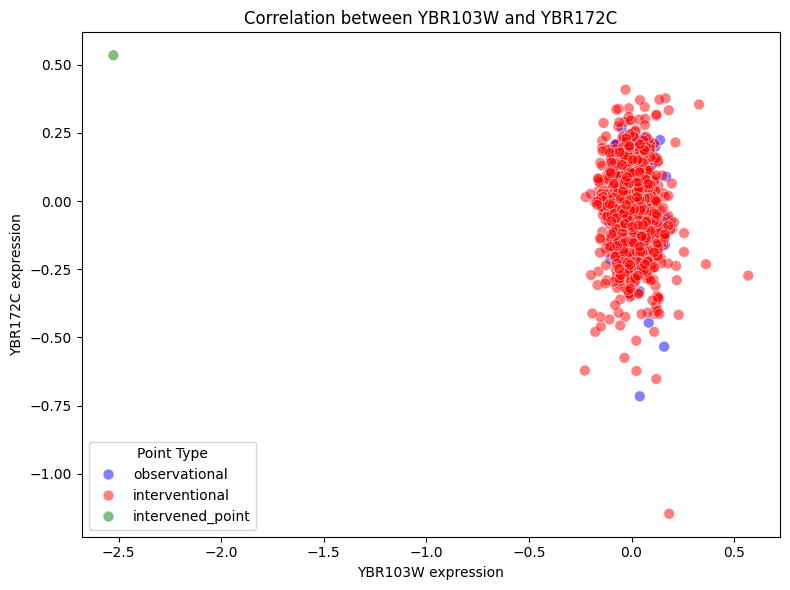

In [135]:
plot_gene_relationship('YBR172C', 'YBR103W', obs_data, int_data, int_pos_data)
